# Import Library

In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from scipy.ndimage import median_filter
from scipy.signal import wiener
from sklearn.metrics import (accuracy_score, classification_report,
                             f1_score, precision_score, recall_score, confusion_matrix)
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torch_lr_finder import LRFinder
from torchvision.datasets import ImageFolder
import seaborn as sns

C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import Dataset

In [2]:
data_dir = './OCT'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

### Data Augmentation

In [3]:
def adjust_gamma(image, gamma=1.0):
    img_array = np.array(image)
    # Build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply gamma correction using the lookup table
    img_array_corrected = cv2.LUT(img_array, table)
    image_corrected = Image.fromarray(img_array_corrected)
    return image_corrected

##### Not used

In [6]:
def replace_white_with_black_and_adjust_gamma(image, gamma=1.0):
    img_array = np.array(image)
    # Convert to grayscale before checking for white pixels
    img_array_gray = np.array(image.convert('L'))
    white_mask = (img_array_gray == 255)  # Check for white pixels in grayscale image
    img_array[white_mask] = [0, 0, 0]  # Replace white pixels with black

    # Apply gamma correction
    img_array_corrected = adjust_gamma(img_array, gamma)

    # Crop image to 224x224 and fill the area outside the box with black
    image_corrected = Image.fromarray(img_array_corrected)

    return image_corrected


##### Continue

In [20]:
data_transforms = {
    TRAIN: transforms.Compose([
        #transforms.RandomResizedCrop(size=224, 
                                     #scale=(0.8, 1.2), 
                                     #ratio=(3/4, 4/3)
                                    #), 
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
        transforms.RandomRotation(30),      # Randomly rotate the image by up to 30 degrees
        transforms.Lambda(lambda x: adjust_gamma(x, gamma=0.75)),  # Apply the custom transformation
        MedianFilterTransform(), 
        transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    ]),
    TEST: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: adjust_gamma(x, gamma=0.75)),  # Apply the custom transformation
        MedianFilterTransform(), 
        transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    ])
}

In [21]:
# Load image datasets
image_datasets = {phase: ImageFolder(os.path.join(data_dir, phase), 
                                     transform=data_transforms[phase]) 
                  for phase in [TRAIN, TEST]}


kf = KFold(n_splits=3, shuffle=True, random_state=42)

dataloaders = []
dataset_sizes = []

# Get the class names from the dataset
class_names = image_datasets[TRAIN].classes
num_classes = 4

batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##### Display the different classes

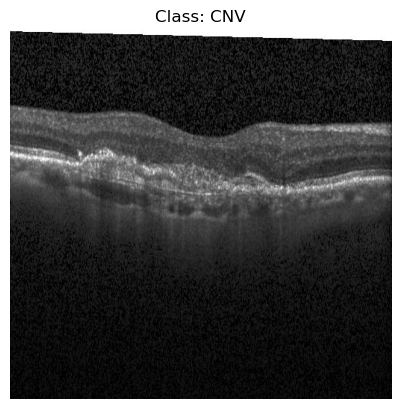

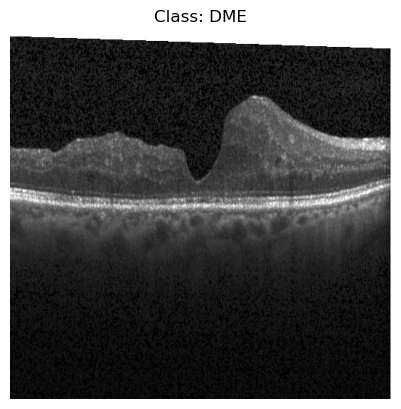

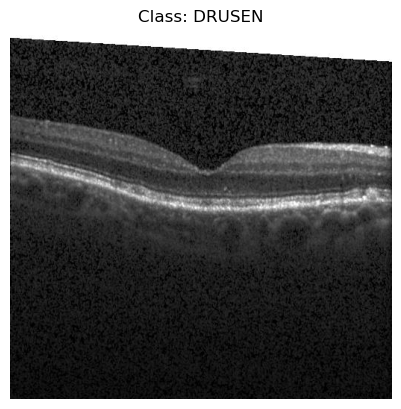

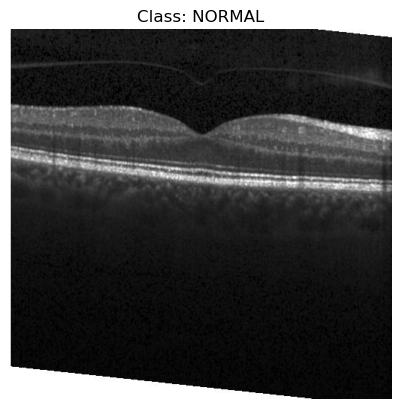

In [13]:
# Display sample images from each class
for class_name in class_names:
    # Find a sample image from the dataset for the current class
    sample_image_path = None
    for path, class_idx in image_datasets[TRAIN].samples:
        if class_idx == class_names.index(class_name):
            sample_image_path = path
            break
    
    # Read the sample image
    sample_image = Image.open(sample_image_path)
    
    # Convert the image to grayscale
    sample_image_gray = sample_image.convert('L')
    
    # Display the sample image in grayscale
    plt.title(f"Class: {class_name}")
    plt.imshow(sample_image_gray, cmap='gray')
    plt.axis('off')
    plt.show()


### Create A Subset

In [22]:
# Create a subset function with uniform sampling
def create_subset(dataset, sampling_rate):
    indices = list(range(len(dataset)))
    num_samples = int(len(indices) * sampling_rate)
    subset_indices = random.sample(indices, num_samples)
    subset = Subset(dataset, subset_indices)
    return subset

In [23]:
# Sampling rate
sampling_rate = 0.1

In [24]:
# Create subsets for training
train_subset = create_subset(image_datasets[TRAIN], sampling_rate)

# K-Fold Cross-Validate

In [25]:
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(range(len(train_subset)))):
    train_dataset = Subset(train_subset, train_idx)
    val_dataset = Subset(train_subset, val_idx)
    test_dataset = image_datasets[TEST]
    
    dataset_sizes.append({TRAIN: len(train_dataset), VAL: len(val_dataset), TEST: len(test_dataset)})  
    
    print(f"Fold {fold_idx + 1}:")
    for phase in [TRAIN, VAL, TEST]:
        print(f"{phase.capitalize()}: {dataset_sizes[fold_idx][phase]} images")
    print()


Fold 1:
Train: 7220 images
Val: 3610 images
Test: 1000 images

Fold 2:
Train: 7220 images
Val: 3610 images
Test: 1000 images

Fold 3:
Train: 7220 images
Val: 3610 images
Test: 1000 images



Fold 1:
Train: 10830 images
Val: 5416 images
Test: 1000 images

Train Sample: torch.Size([1, 224, 224])


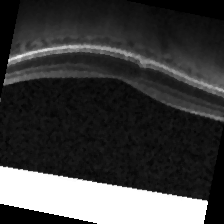

Validation Sample: torch.Size([1, 224, 224])


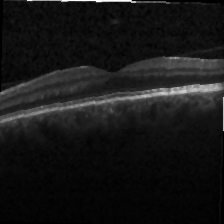

Test Sample: torch.Size([1, 224, 224])


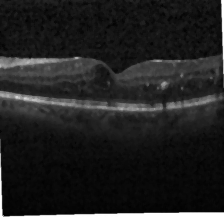

Fold 2:
Train: 10831 images
Val: 5415 images
Test: 1000 images

Train Sample: torch.Size([1, 224, 224])


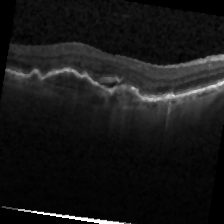

Validation Sample: torch.Size([1, 224, 224])


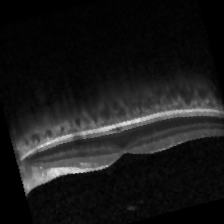

Test Sample: torch.Size([1, 224, 224])


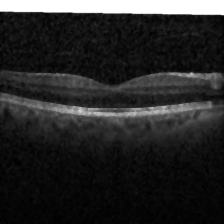

Fold 3:
Train: 10831 images
Val: 5415 images
Test: 1000 images

Train Sample: torch.Size([1, 224, 224])


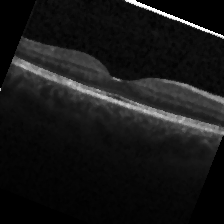

Validation Sample: torch.Size([1, 224, 224])


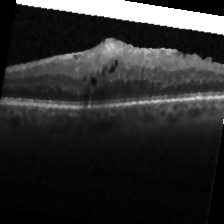

Test Sample: torch.Size([1, 224, 224])


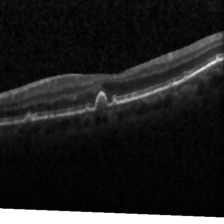

In [12]:
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(range(len(train_subset)))):
    print(f"Fold {fold_idx + 1}:")
    for phase in [TRAIN, VAL, TEST]:
        print(f"{phase.capitalize()}: {dataset_sizes[fold_idx][phase]} images")
    print()
    
    train_sample = random.choice(train_dataset)
    test_sample = random.choice(test_dataset)

    train_image = transforms.ToPILImage()(train_sample[0])
    test_image = transforms.ToPILImage()(test_sample[0])

    print("Train Sample:", train_sample[0].shape)  # Debugging print
    display(train_image)

    if len(val_dataset) > 0:
        val_sample = random.choice(val_dataset)
        val_image = transforms.ToPILImage()(val_sample[0])
        print("Validation Sample:", val_sample[0].shape)  # Debugging print
        display(val_image)

    print("Test Sample:", test_sample[0].shape)  # Debugging print
    display(test_image)

# Speckle Denoise Filter

#### Median Filter

In [4]:
def apply_median_filter(image_array):
    res = median_filter(image_array, size=3)
    return res

#### Wiener Filter

In [6]:
def apply_wiener_filter(image_array):
    res = wiener(image_array, mysize=3)
    return res

## Apply that Filter

### test

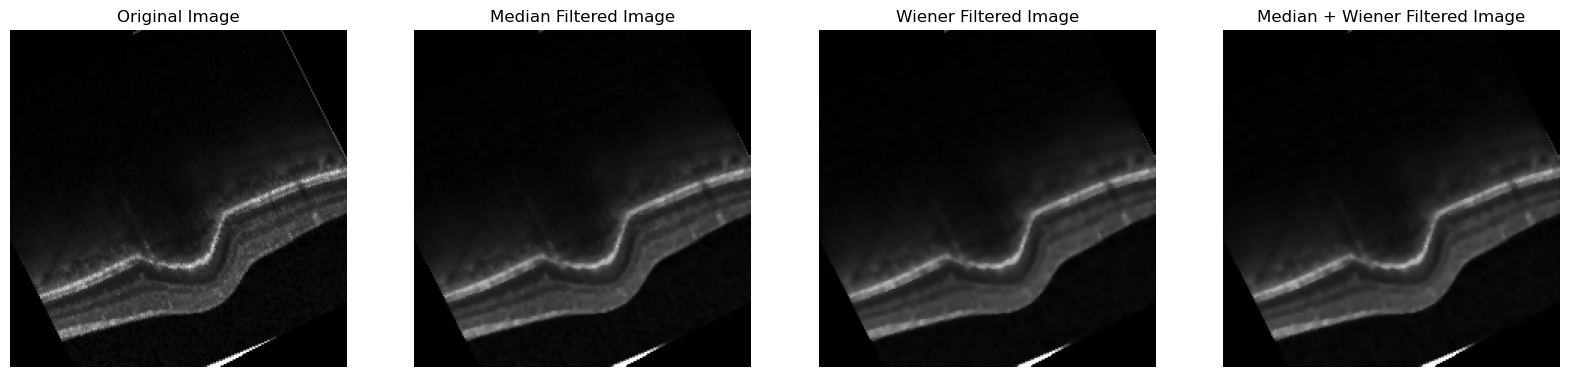

In [16]:
# Load a random training image using OpenCV
random_idx = np.random.randint(0, len(train_dataset))
random_sample = train_dataset[random_idx]
random_image_array = random_sample[0].permute(1, 2, 0).numpy()

# Check the number of channels
num_channels = random_image_array.shape[2] if random_image_array.ndim == 3 else 1

# Convert the image to grayscale if it has multiple channels
if num_channels > 1:
    gray_image_array = cv2.cvtColor(random_image_array, cv2.COLOR_RGB2GRAY)
else:
    gray_image_array = random_image_array.squeeze()  # Ensure 2D format

# Normalize the input image to the range [0, 1] for filtering
gray_image_array_normalized = gray_image_array / 255.0

# Apply Median filter
median_filtered_image = apply_median_filter(gray_image_array_normalized)

# Apply Wiener filter using scipy
wiener_filtered_image = apply_wiener_filter(median_filtered_image)

# Convert images to displayable format
median_filtered_image_display = median_filtered_image
wiener_filtered_image_display = wiener_filtered_image

# Display the original, Median filtered, Wiener filtered, and their combinations
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(gray_image_array, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(median_filtered_image_display, cmap='gray')
axes[1].set_title("Median Filtered Image")
axes[1].axis("off")
axes[2].imshow(wiener_filtered_image_display, cmap='gray')
axes[2].set_title("Wiener Filtered Image")
axes[2].axis("off")
axes[3].imshow(wiener_filtered_image_display, cmap='gray')
axes[3].set_title("Median + Wiener Filtered Image")
axes[3].axis("off")
plt.show()

### Apply the median Filter

In [5]:
class MedianFilterTransform:
    def __call__(self, img):
        img_array = np.array(img)
        
        if len(img_array.shape) == 3:  # RGB image
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        
        # Apply median filter
        median_filtered_image = apply_median_filter(img_array)
        
        return Image.fromarray(median_filtered_image)

### Apply the Wiener Filter

In [7]:
class WienerFilterTransform:
    def __call__(self, img):
        img_array = np.array(img)
        if len(img_array.shape) == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        
        # Normalize the image array to [0, 1]
        img_array_normalized = img_array / 255.0
        
        # Apply the Wiener filter
        wiener_filtered_image = apply_wiener_filter(img_array_normalized)
        
        # Denormalize the filtered image back to [0, 255]
        wiener_filtered_image = (wiener_filtered_image * 255).astype(np.uint8)
        
        # Handle cases where Wiener filter output is invalid
        wiener_filtered_image = np.nan_to_num(wiener_filtered_image)
        
        return Image.fromarray(wiener_filtered_image)

### Apply Median + Wiener Filter

In [12]:
# Custom transform that applies both the Median and Wiener filters
class CombinedFilterTransform:
    def __call__(self, img):
        # Convert to numpy array
        img_array = np.array(img)
        
        # Convert to grayscale if needed
        if len(img_array.shape) == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        
        # Apply median filter
        median_filtered_image = apply_median_filter(img_array)
        
        # Normalize the image to range [0, 1]
        median_filtered_image_normalized = median_filtered_image / 255.0
        
        # Apply Wiener filter
        wiener_filtered_image = apply_wiener_filter(median_filtered_image_normalized)
        
        # Denormalize the image back to range [0, 255]
        wiener_filtered_image_denormalized = (wiener_filtered_image * 255).astype(np.uint8)
        
        # Handle any invalid values
        wiener_filtered_image_denormalized = np.nan_to_num(wiener_filtered_image_denormalized)
        
        # Convert back to PIL image
        return Image.fromarray(wiener_filtered_image_denormalized)

## Evaluate Each Model

In [20]:
data_transforms = {
    "normal": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
        transforms.RandomRotation(30),      # Randomly rotate the image by up to 30 degrees
        transforms.Lambda(lambda x: adjust_gamma(x, gamma=0.75)),  # Apply the custom transformation
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]),
    "wiener": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
        transforms.RandomRotation(30),      # Randomly rotate the image by up to 30 degrees
        WienerFilterTransform(),
        transforms.Lambda(lambda x: adjust_gamma(x, gamma=0.75)),  # Apply the custom transformation
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]),
    "median": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
        transforms.RandomRotation(30),      # Randomly rotate the image by up to 30 degrees
        MedianFilterTransform(),
        transforms.Lambda(lambda x: adjust_gamma(x, gamma=0.75)),  # Apply the custom transformation
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]),
    "combined": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
        transforms.RandomRotation(30),      # Randomly rotate the image by up to 30 degrees
        CombinedFilterTransform(),
        transforms.Lambda(lambda x: adjust_gamma(x, gamma=0.75)),  # Apply the custom transformation
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
}


In [21]:
# Define filter names
filter_names = ["normal", "wiener", "median", "combined"]

# Create image datasets for each filter type
image_datasets_filter = {filter_name: ImageFolder(data_dir, transform=data_transforms[filter_name]) for filter_name in filter_names}

# Now, you can proceed with creating subsets and training
train_subsets = {filter_name: create_subset(image_datasets_filter[filter_name], sampling_rate) for filter_name in filter_names}
test_subsets = {filter_name: create_subset(image_datasets_filter[filter_name], sampling_rate) for filter_name in filter_names}


In [25]:
def train_and_evaluate_subsets(subsets, device, num_epochs=10):
    for filter_name, subset in subsets.items():
        print(f"Evaluating filter: {filter_name}")
        dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        model = ResNetGrayMulticlass(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            predictions = []
            true_labels = []

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.tolist())
                true_labels.extend(labels.tolist())

            epoch_loss = running_loss / len(dataloader.dataset)
            accuracy = accuracy_score(true_labels, predictions)
            precision = precision_score(true_labels, predictions, average='weighted', zero_division=1)
            recall = recall_score(true_labels, predictions, average='weighted')
            f1 = f1_score(true_labels, predictions, average='weighted')

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

        # Save the model for the current filter
        model_path = f"Filtered_ResNet50_{filter_name}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model for filter {filter_name} saved to {model_path}")

    return

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train and evaluate subsets
train_and_evaluate_subsets(train_subsets, device)

Evaluating filter: normal
Epoch 1/10, Loss: 0.0909, Accuracy: 0.9791, Precision: 0.9819, Recall: 0.9791, F1-score: 0.9805
Epoch 2/10, Loss: 0.0475, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Epoch 3/10, Loss: 0.0496, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Epoch 4/10, Loss: 0.0468, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Epoch 5/10, Loss: 0.0454, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Epoch 6/10, Loss: 0.0410, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Epoch 7/10, Loss: 0.0477, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Epoch 8/10, Loss: 0.0431, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Epoch 9/10, Loss: 0.0401, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Epoch 10/10, Loss: 0.0420, Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1-score: 0.9863
Model for fil

# Model Define

## ResNet50

In [11]:
# Define a custom ResNet model for grayscale images for multiclass classification
class ResNetGrayMulticlass(nn.Module):
    def __init__(self, num_classes):
        super(ResNetGrayMulticlass, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # Replace the first convolutional layer to accept one channel
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Replace the final fully connected layer for multiclass classification
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet50(x)

## InceptionV3

In [12]:
# Define a custom InceptionV3 model for grayscale images for multiclass classification
class InceptionV3GrayMulticlass(nn.Module):
    def __init__(self, num_classes):
        super(InceptionV3GrayMulticlass, self).__init__()
        self.inception_v3 = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        
        # Modify the first convolutional layer to accept one channel
        self.inception_v3.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=0, bias=False)
        
        # Replace the final fully connected layer for multiclass classification
        num_ftrs = self.inception_v3.fc.in_features
        self.inception_v3.fc = nn.Linear(num_ftrs, num_classes)
        
        # Disable the auxiliary classifier
        self.inception_v3.aux_logits = False

        # Disable input transformation
        self.inception_v3.transform_input = False

    def forward(self, x):
        x = self.inception_v3._transform_input(x)
        x = self.inception_v3.Conv2d_1a_3x3(x)
        x = self.inception_v3.Conv2d_2a_3x3(x)
        x = self.inception_v3.Conv2d_2b_3x3(x)
        x = self.inception_v3.maxpool1(x)
        x = self.inception_v3.Conv2d_3b_1x1(x)
        x = self.inception_v3.Conv2d_4a_3x3(x)
        x = self.inception_v3.maxpool2(x)
        x = self.inception_v3.Mixed_5b(x)
        x = self.inception_v3.Mixed_5c(x)
        x = self.inception_v3.Mixed_5d(x)
        x = self.inception_v3.Mixed_6a(x)
        x = self.inception_v3.Mixed_6b(x)
        x = self.inception_v3.Mixed_6c(x)
        x = self.inception_v3.Mixed_6d(x)
        x = self.inception_v3.Mixed_6e(x)
        x = self.inception_v3.Mixed_7a(x)
        x = self.inception_v3.Mixed_7b(x)
        x = self.inception_v3.Mixed_7c(x)
        x = self.inception_v3.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.inception_v3.dropout(x)
        x = self.inception_v3.fc(x)
        return x

## DenseNet121

In [13]:
# Define a custom DenseNet121 model for grayscale images for multiclass classification
class DenseNet121GrayMulticlass(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121GrayMulticlass, self).__init__()
        self.densenet121 = models.densenet121(pretrained=True)
        # Replace the first convolutional layer to accept one channel
        self.densenet121.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Replace the final fully connected layer for multiclass classification
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.densenet121(x)


## Ensemble (ResNet50 + InceptionV3)

In [14]:
# Define a custom ensemble model for multiclass classification
class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super(EnsembleModel, self).__init__()
        self.resnet_model = ResNetGrayMulticlass(num_classes)
        self.inception_model = InceptionV3GrayMulticlass(num_classes)
        self.num_classes = num_classes
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        resnet_out = self.resnet_model(x)
        inception_out = self.inception_model(x)
        combined_out = torch.cat((resnet_out, inception_out), dim=1)
        final_out = self.fc(combined_out)
        return final_out

# Train the Data

In [15]:
num_epochs = 10
NUM_FOLDS = 3

batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Learning Rate Finder

In [12]:
def lr_finder(model_class):

    train_size = int(0.8 * len(image_datasets[TRAIN]))
    val_size = len(image_datasets[TRAIN]) - train_size
    train_dataset, val_dataset = random_split(image_datasets[TRAIN], [train_size, val_size])

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
    
    # Initialize your model, criterion, and optimizer
    model = model_class(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-7)

    # Initialize and run the learning rate finder
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(train_dataloader, end_lr=10, num_iter=100)
    lr_finder.plot()  # to plot the lr vs loss

    return

#### LR Finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.48E-04


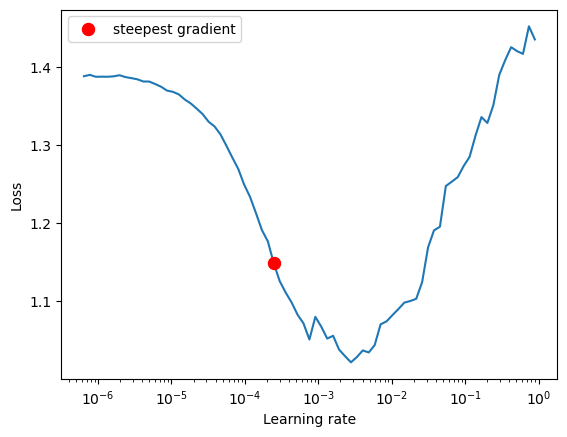

In [61]:
lr_finder(ResNetGrayMulticlass)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.32E-03


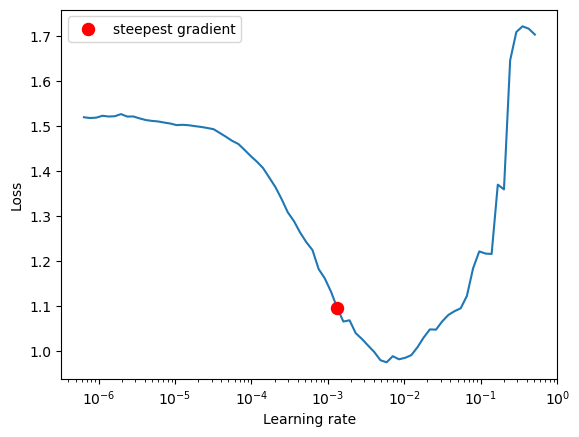

In [73]:
lr_finder(InceptionV3GrayMulticlass)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.56E-04


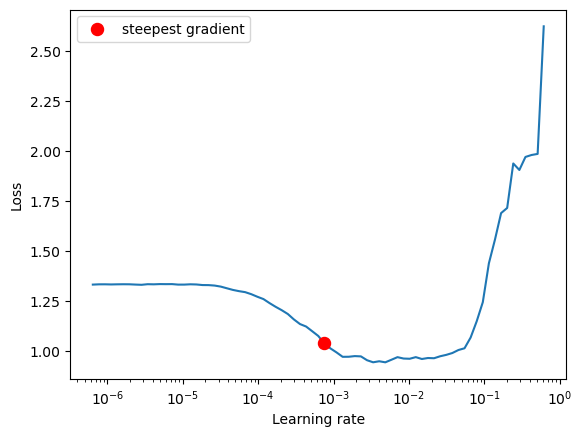

In [74]:
lr_finder(DenseNet121GrayMulticlass)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.56E-04


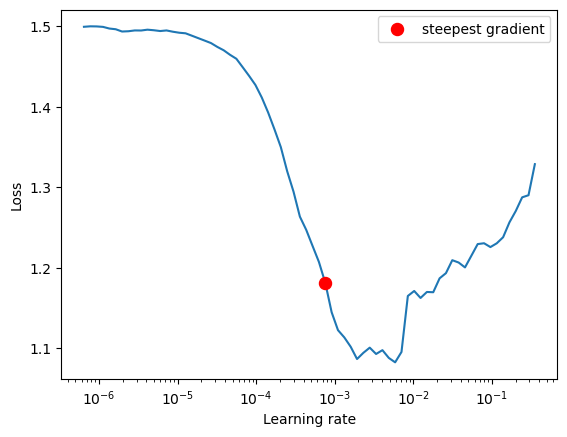

In [75]:
lr_finder(EnsembleModel)

## Learning Rates

In [16]:
lrResNet = 2.48E-04

In [17]:
lrInception = 1.32E-03

In [18]:
lrDense = 7.56E-04

In [19]:
lrEnsemble = 7.56E-04

## Train Function

In [20]:
# Training function for a single model and epoch
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):  # Loop over the dataset multiple times
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Initialize running loss
        predictions, true_labels = [], []  # Initialize lists to collect predictions and true labels
        
        for inputs, labels in dataloaders['train']:  # Iterate over the training data
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU if available
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            inputs_gray = inputs.mean(dim=1, keepdim=True)  # Convert inputs to grayscale
            outputs = model(inputs_gray)  # Forward pass
            
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model
            
            running_loss += loss.item() * inputs.size(0)  # Accumulate the loss
            
            _, preds = torch.max(outputs, 1)  # Get the predicted classes
            predictions.extend(preds.tolist())  # Store predictions
            true_labels.extend(labels.tolist())  # Store true labels
        
        # Calculate and print metrics after each epoch
        epoch_loss = running_loss / len(dataloaders['train'].dataset)  # Average loss
        accuracy = accuracy_score(true_labels, predictions)  # Accuracy
        precision = precision_score(true_labels, predictions, average='weighted', zero_division=1)  # Precision
        recall = recall_score(true_labels, predictions, average='weighted')  # Recall
        f1 = f1_score(true_labels, predictions, average='weighted')  # F1 score
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    return model  # Return the trained model

In [21]:
# K-Fold Cross Validation function
def cross_validate_model(model_class, num_classes, kf, train_subset, lrModel):
    dataloaders, dataset_sizes = [], []  # Initialize lists to store dataloaders and dataset sizes for each fold
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(range(len(train_subset)))):  # Iterate over folds
        # Create training and validation subsets for the current fold
        train_dataset = Subset(train_subset, train_idx)
        val_dataset = Subset(train_subset, val_idx)
        test_dataset = image_datasets[TEST]  # Use the same test dataset for all folds
        
        # Create dataloaders for the current fold
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
        
        # Store the dataloaders and dataset sizes
        dataloaders.append({'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader})
        dataset_sizes.append({'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)})
        
        print(f"Fold {fold_idx + 1}: Train: {dataset_sizes[fold_idx]['train']} images, Val: {dataset_sizes[fold_idx]['val']} images, Test: {dataset_sizes[fold_idx]['test']} images")
        
        # Initialize the model for the current fold
        model = model_class(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()  # Define the loss function
        optimizer = optim.Adam(model.parameters(), lr=lrModel)  # Define the optimizer
        
        # Train the model on the current fold
        trained_model = train_model(model, dataloaders[fold_idx], criterion, optimizer)
        
        # Save the trained model's state
        model_path = f"{model_class.__name__.lower()}_fold_{fold_idx + 1}.pth"
        torch.save(trained_model.state_dict(), model_path)
        print(f"Model for fold {fold_idx + 1} saved to {model_path}")

In [22]:
import warnings
warnings.filterwarnings("ignore")

## Speckle Denoise 

### No Filter = 0.9297

In [36]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.5933, Accuracy: 0.7997, Precision: 0.7702, Recall: 0.7997, F1-score: 0.7756
Epoch 2/10, Loss: 0.3843, Accuracy: 0.8740, Precision: 0.8608, Recall: 0.8740, F1-score: 0.8633
Epoch 3/10, Loss: 0.3041, Accuracy: 0.8989, Precision: 0.8911, Recall: 0.8989, F1-score: 0.8922
Epoch 4/10, Loss: 0.2700, Accuracy: 0.9147, Precision: 0.9101, Recall: 0.9147, F1-score: 0.9107
Epoch 5/10, Loss: 0.2531, Accuracy: 0.9130, Precision: 0.9086, Recall: 0.9130, F1-score: 0.9098
Epoch 6/10, Loss: 0.2428, Accuracy: 0.9238, Precision: 0.9202, Recall: 0.9238, F1-score: 0.9208
Epoch 7/10, Loss: 0.2294, Accuracy: 0.9230, Precision: 0.9197, Recall: 0.9230, F1-score: 0.9207
Epoch 8/10, Loss: 0.2300, Accuracy: 0.9208, Precision: 0.9171, Recall: 0.9208, F1-score: 0.9180
Epoch 9/10, Loss: 0.2010, Accuracy: 0.9366, Precision: 0.9339, Recall: 0.9366, F1-score: 0.9343
Epoch 10/10, Loss: 0.1974, Accuracy: 0.9368, Precision: 0.9344, Recall: 

### Median = 0.9326

In [27]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.6027, Accuracy: 0.7945, Precision: 0.7606, Recall: 0.7945, F1-score: 0.7667
Epoch 2/10, Loss: 0.3764, Accuracy: 0.8751, Precision: 0.8589, Recall: 0.8751, F1-score: 0.8631
Epoch 3/10, Loss: 0.3259, Accuracy: 0.8950, Precision: 0.8864, Recall: 0.8950, F1-score: 0.8869
Epoch 4/10, Loss: 0.2682, Accuracy: 0.9152, Precision: 0.9104, Recall: 0.9152, F1-score: 0.9109
Epoch 5/10, Loss: 0.2670, Accuracy: 0.9141, Precision: 0.9091, Recall: 0.9141, F1-score: 0.9102
Epoch 6/10, Loss: 0.2729, Accuracy: 0.9130, Precision: 0.9080, Recall: 0.9130, F1-score: 0.9086
Epoch 7/10, Loss: 0.2215, Accuracy: 0.9296, Precision: 0.9266, Recall: 0.9296, F1-score: 0.9274
Epoch 8/10, Loss: 0.2260, Accuracy: 0.9249, Precision: 0.9208, Recall: 0.9249, F1-score: 0.9216
Epoch 9/10, Loss: 0.2161, Accuracy: 0.9355, Precision: 0.9328, Recall: 0.9355, F1-score: 0.9332
Epoch 10/10, Loss: 0.2237, Accuracy: 0.9263, Precision: 0.9228, Recall: 

### Weiner = 0.9274

In [45]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.6494, Accuracy: 0.7787, Precision: 0.7387, Recall: 0.7787, F1-score: 0.7482
Epoch 2/10, Loss: 0.4122, Accuracy: 0.8620, Precision: 0.8457, Recall: 0.8620, F1-score: 0.8492
Epoch 3/10, Loss: 0.3285, Accuracy: 0.8903, Precision: 0.8833, Recall: 0.8903, F1-score: 0.8846
Epoch 4/10, Loss: 0.2992, Accuracy: 0.9028, Precision: 0.8970, Recall: 0.9028, F1-score: 0.8982
Epoch 5/10, Loss: 0.2701, Accuracy: 0.9075, Precision: 0.9042, Recall: 0.9075, F1-score: 0.9053
Epoch 6/10, Loss: 0.2373, Accuracy: 0.9230, Precision: 0.9198, Recall: 0.9230, F1-score: 0.9204
Epoch 7/10, Loss: 0.2530, Accuracy: 0.9166, Precision: 0.9136, Recall: 0.9166, F1-score: 0.9144
Epoch 8/10, Loss: 0.2284, Accuracy: 0.9274, Precision: 0.9245, Recall: 0.9274, F1-score: 0.9248
Epoch 9/10, Loss: 0.2159, Accuracy: 0.9302, Precision: 0.9279, Recall: 0.9302, F1-score: 0.9285
Epoch 10/10, Loss: 0.2134, Accuracy: 0.9283, Precision: 0.9264, Recall: 

### Combined = 0.9271

In [55]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.6672, Accuracy: 0.7679, Precision: 0.7312, Recall: 0.7679, F1-score: 0.7419
Epoch 2/10, Loss: 0.3919, Accuracy: 0.8712, Precision: 0.8579, Recall: 0.8712, F1-score: 0.8589
Epoch 3/10, Loss: 0.3665, Accuracy: 0.8726, Precision: 0.8616, Recall: 0.8726, F1-score: 0.8639
Epoch 4/10, Loss: 0.3019, Accuracy: 0.8997, Precision: 0.8936, Recall: 0.8997, F1-score: 0.8945
Epoch 5/10, Loss: 0.2863, Accuracy: 0.9033, Precision: 0.8979, Recall: 0.9033, F1-score: 0.8992
Epoch 6/10, Loss: 0.2606, Accuracy: 0.9127, Precision: 0.9087, Recall: 0.9127, F1-score: 0.9092
Epoch 7/10, Loss: 0.2493, Accuracy: 0.9147, Precision: 0.9112, Recall: 0.9147, F1-score: 0.9122
Epoch 8/10, Loss: 0.2231, Accuracy: 0.9247, Precision: 0.9220, Recall: 0.9247, F1-score: 0.9225
Epoch 9/10, Loss: 0.2205, Accuracy: 0.9233, Precision: 0.9208, Recall: 0.9233, F1-score: 0.9215
Epoch 10/10, Loss: 0.2232, Accuracy: 0.9260, Precision: 0.9238, Recall: 

## With Translation

### With UnPrecision Translation = 0.8503

In [26]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.7913, Accuracy: 0.7263, Precision: 0.6767, Recall: 0.7263, F1-score: 0.6829
Epoch 2/10, Loss: 0.5965, Accuracy: 0.7889, Precision: 0.7723, Recall: 0.7889, F1-score: 0.7661
Epoch 3/10, Loss: 0.5278, Accuracy: 0.8091, Precision: 0.7947, Recall: 0.8091, F1-score: 0.7930
Epoch 4/10, Loss: 0.4948, Accuracy: 0.8227, Precision: 0.8150, Recall: 0.8227, F1-score: 0.8122
Epoch 5/10, Loss: 0.4624, Accuracy: 0.8357, Precision: 0.8290, Recall: 0.8357, F1-score: 0.8267
Epoch 6/10, Loss: 0.4358, Accuracy: 0.8421, Precision: 0.8350, Recall: 0.8421, F1-score: 0.8347
Epoch 7/10, Loss: 0.4290, Accuracy: 0.8446, Precision: 0.8385, Recall: 0.8446, F1-score: 0.8361
Epoch 8/10, Loss: 0.4290, Accuracy: 0.8463, Precision: 0.8411, Recall: 0.8463, F1-score: 0.8391
Epoch 9/10, Loss: 0.4097, Accuracy: 0.8532, Precision: 0.8480, Recall: 0.8532, F1-score: 0.8461
Epoch 10/10, Loss: 0.3926, Accuracy: 0.8593, Precision: 0.8551, Recall: 

### With Precision Translation = 0.9270

In [20]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.6128, Accuracy: 0.7928, Precision: 0.7700, Recall: 0.7928, F1-score: 0.7701
Epoch 2/10, Loss: 0.4007, Accuracy: 0.8643, Precision: 0.8537, Recall: 0.8643, F1-score: 0.8554
Epoch 3/10, Loss: 0.3343, Accuracy: 0.8911, Precision: 0.8850, Recall: 0.8911, F1-score: 0.8855
Epoch 4/10, Loss: 0.2833, Accuracy: 0.9102, Precision: 0.9062, Recall: 0.9102, F1-score: 0.9058
Epoch 5/10, Loss: 0.2856, Accuracy: 0.9083, Precision: 0.9046, Recall: 0.9083, F1-score: 0.9047
Epoch 6/10, Loss: 0.2781, Accuracy: 0.9114, Precision: 0.9079, Recall: 0.9114, F1-score: 0.9084
Epoch 7/10, Loss: 0.2583, Accuracy: 0.9183, Precision: 0.9154, Recall: 0.9183, F1-score: 0.9159
Epoch 8/10, Loss: 0.2382, Accuracy: 0.9208, Precision: 0.9182, Recall: 0.9208, F1-score: 0.9188
Epoch 9/10, Loss: 0.2434, Accuracy: 0.9227, Precision: 0.9204, Recall: 0.9227, F1-score: 0.9205
Epoch 10/10, Loss: 0.2010, Accuracy: 0.9324, Precision: 0.9305, Recall: 

## 0.05

### ResNet

#### ResNet50

In [45]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.6191, Accuracy: 0.7789, Precision: 0.7411, Recall: 0.7789, F1-score: 0.7536
Epoch 2/10, Loss: 0.3860, Accuracy: 0.8729, Precision: 0.8600, Recall: 0.8729, F1-score: 0.8611
Epoch 3/10, Loss: 0.3374, Accuracy: 0.8861, Precision: 0.8769, Recall: 0.8861, F1-score: 0.8777
Epoch 4/10, Loss: 0.3005, Accuracy: 0.8997, Precision: 0.8926, Recall: 0.8997, F1-score: 0.8931
Epoch 5/10, Loss: 0.2878, Accuracy: 0.9069, Precision: 0.9013, Recall: 0.9069, F1-score: 0.9019
Epoch 6/10, Loss: 0.2626, Accuracy: 0.9139, Precision: 0.9092, Recall: 0.9139, F1-score: 0.9098
Epoch 7/10, Loss: 0.2427, Accuracy: 0.9186, Precision: 0.9148, Recall: 0.9186, F1-score: 0.9159
Epoch 8/10, Loss: 0.2193, Accuracy: 0.9313, Precision: 0.9287, Recall: 0.9313, F1-score: 0.9290
Epoch 9/10, Loss: 0.2462, Accuracy: 0.9238, Precision: 0.9207, Recall: 0.9238, F1-score: 0.9208
Epoch 10/10, Loss: 0.2060, Accuracy: 0.9299, Precision: 0.9275, Recall: 

### InceptionV3

In [64]:
cross_validate_model(InceptionV3GrayMulticlass, num_classes, kf, train_subset, lrInception)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.6703, Accuracy: 0.7837, Precision: 0.7284, Recall: 0.7837, F1-score: 0.7432
Epoch 2/10, Loss: 0.4757, Accuracy: 0.8435, Precision: 0.8233, Recall: 0.8435, F1-score: 0.8239
Epoch 3/10, Loss: 0.3807, Accuracy: 0.8723, Precision: 0.8632, Recall: 0.8723, F1-score: 0.8652
Epoch 4/10, Loss: 0.3457, Accuracy: 0.8898, Precision: 0.8834, Recall: 0.8898, F1-score: 0.8839
Epoch 5/10, Loss: 0.3151, Accuracy: 0.9003, Precision: 0.8957, Recall: 0.9003, F1-score: 0.8967
Epoch 6/10, Loss: 0.2882, Accuracy: 0.9058, Precision: 0.9010, Recall: 0.9058, F1-score: 0.9019
Epoch 7/10, Loss: 0.2599, Accuracy: 0.9208, Precision: 0.9177, Recall: 0.9208, F1-score: 0.9181
Epoch 8/10, Loss: 0.2662, Accuracy: 0.9122, Precision: 0.9098, Recall: 0.9122, F1-score: 0.9106
Epoch 9/10, Loss: 0.2450, Accuracy: 0.9252, Precision: 0.9227, Recall: 0.9252, F1-score: 0.9229
Epoch 10/10, Loss: 0.2191, Accuracy: 0.9310, Precision: 0.9292, Recall: 

### DenseNet 121

In [65]:
cross_validate_model(DenseNet121GrayMulticlass, num_classes, kf, train_subset, lrDense)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.6473, Accuracy: 0.7859, Precision: 0.7441, Recall: 0.7859, F1-score: 0.7514
Epoch 2/10, Loss: 0.3963, Accuracy: 0.8698, Precision: 0.8594, Recall: 0.8698, F1-score: 0.8595
Epoch 3/10, Loss: 0.3330, Accuracy: 0.8903, Precision: 0.8831, Recall: 0.8903, F1-score: 0.8841
Epoch 4/10, Loss: 0.3085, Accuracy: 0.8972, Precision: 0.8921, Recall: 0.8972, F1-score: 0.8928
Epoch 5/10, Loss: 0.2844, Accuracy: 0.9058, Precision: 0.9014, Recall: 0.9058, F1-score: 0.9024
Epoch 6/10, Loss: 0.2546, Accuracy: 0.9161, Precision: 0.9120, Recall: 0.9161, F1-score: 0.9126
Epoch 7/10, Loss: 0.2452, Accuracy: 0.9125, Precision: 0.9085, Recall: 0.9125, F1-score: 0.9096
Epoch 8/10, Loss: 0.2443, Accuracy: 0.9213, Precision: 0.9184, Recall: 0.9213, F1-score: 0.9191
Epoch 9/10, Loss: 0.2271, Accuracy: 0.9280, Precision: 0.9254, Recall: 0.9280, F1-score: 0.9259
Epoch 10/10, Loss: 0.2049, Accuracy: 0.9305, Precision: 0.9282, Recall: 

### InceptionV3 + ResNet50

In [66]:
cross_validate_model(EnsembleModel, num_classes, kf, train_subset, lrEnsemble)

Fold 1: Train: 3610 images, Val: 1805 images, Test: 1000 images
Epoch 1/10, Loss: 0.6494, Accuracy: 0.7931, Precision: 0.7253, Recall: 0.7931, F1-score: 0.7540
Epoch 2/10, Loss: 0.4009, Accuracy: 0.8673, Precision: 0.8544, Recall: 0.8673, F1-score: 0.8560
Epoch 3/10, Loss: 0.3537, Accuracy: 0.8817, Precision: 0.8740, Recall: 0.8817, F1-score: 0.8752
Epoch 4/10, Loss: 0.3038, Accuracy: 0.9017, Precision: 0.8959, Recall: 0.9017, F1-score: 0.8972
Epoch 5/10, Loss: 0.2773, Accuracy: 0.9127, Precision: 0.9084, Recall: 0.9127, F1-score: 0.9082
Epoch 6/10, Loss: 0.2654, Accuracy: 0.9152, Precision: 0.9117, Recall: 0.9152, F1-score: 0.9126
Epoch 7/10, Loss: 0.2355, Accuracy: 0.9194, Precision: 0.9163, Recall: 0.9194, F1-score: 0.9171
Epoch 8/10, Loss: 0.2443, Accuracy: 0.9230, Precision: 0.9204, Recall: 0.9230, F1-score: 0.9210
Epoch 9/10, Loss: 0.2175, Accuracy: 0.9255, Precision: 0.9222, Recall: 0.9255, F1-score: 0.9229
Epoch 10/10, Loss: 0.2018, Accuracy: 0.9330, Precision: 0.9305, Recall: 

## 0.1

### ResNet

#### ResNet50

In [74]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 7220 images, Val: 3610 images, Test: 1000 images
Epoch 1/10, Loss: 0.5271, Accuracy: 0.8158, Precision: 0.7943, Recall: 0.8158, F1-score: 0.7975
Epoch 2/10, Loss: 0.3211, Accuracy: 0.8954, Precision: 0.8902, Recall: 0.8954, F1-score: 0.8910
Epoch 3/10, Loss: 0.2844, Accuracy: 0.9043, Precision: 0.9003, Recall: 0.9043, F1-score: 0.9013
Epoch 4/10, Loss: 0.2342, Accuracy: 0.9247, Precision: 0.9220, Recall: 0.9247, F1-score: 0.9225
Epoch 5/10, Loss: 0.2237, Accuracy: 0.9265, Precision: 0.9240, Recall: 0.9265, F1-score: 0.9244
Epoch 6/10, Loss: 0.2182, Accuracy: 0.9283, Precision: 0.9265, Recall: 0.9283, F1-score: 0.9268
Epoch 7/10, Loss: 0.2073, Accuracy: 0.9325, Precision: 0.9306, Recall: 0.9325, F1-score: 0.9311
Epoch 8/10, Loss: 0.1948, Accuracy: 0.9343, Precision: 0.9326, Recall: 0.9343, F1-score: 0.9331
Epoch 9/10, Loss: 0.1901, Accuracy: 0.9380, Precision: 0.9363, Recall: 0.9380, F1-score: 0.9367
Epoch 10/10, Loss: 0.1825, Accuracy: 0.9407, Precision: 0.9392, Recall: 

### InceptionV3

In [25]:
cross_validate_model(InceptionV3GrayMulticlass, num_classes, kf, train_subset, lrInception)

Fold 1: Train: 7220 images, Val: 3610 images, Test: 1000 images
Epoch 1/10, Loss: 0.6351, Accuracy: 0.7773, Precision: 0.7486, Recall: 0.7773, F1-score: 0.7480
Epoch 2/10, Loss: 0.3737, Accuracy: 0.8767, Precision: 0.8689, Recall: 0.8767, F1-score: 0.8699
Epoch 3/10, Loss: 0.3037, Accuracy: 0.9030, Precision: 0.8985, Recall: 0.9030, F1-score: 0.8993
Epoch 4/10, Loss: 0.2696, Accuracy: 0.9159, Precision: 0.9131, Recall: 0.9159, F1-score: 0.9134
Epoch 5/10, Loss: 0.2436, Accuracy: 0.9237, Precision: 0.9213, Recall: 0.9237, F1-score: 0.9218
Epoch 6/10, Loss: 0.2454, Accuracy: 0.9184, Precision: 0.9154, Recall: 0.9184, F1-score: 0.9162
Epoch 7/10, Loss: 0.2062, Accuracy: 0.9277, Precision: 0.9255, Recall: 0.9277, F1-score: 0.9261
Epoch 8/10, Loss: 0.1934, Accuracy: 0.9356, Precision: 0.9343, Recall: 0.9356, F1-score: 0.9347
Epoch 9/10, Loss: 0.2084, Accuracy: 0.9301, Precision: 0.9285, Recall: 0.9301, F1-score: 0.9290
Epoch 10/10, Loss: 0.1815, Accuracy: 0.9402, Precision: 0.9389, Recall: 

### DenseNet 121

In [26]:
cross_validate_model(DenseNet121GrayMulticlass, num_classes, kf, train_subset, lrDense)

Fold 1: Train: 7220 images, Val: 3610 images, Test: 1000 images
Epoch 1/10, Loss: 0.4993, Accuracy: 0.8289, Precision: 0.8115, Recall: 0.8289, F1-score: 0.8149
Epoch 2/10, Loss: 0.3314, Accuracy: 0.8896, Precision: 0.8828, Recall: 0.8896, F1-score: 0.8837
Epoch 3/10, Loss: 0.2794, Accuracy: 0.9111, Precision: 0.9077, Recall: 0.9111, F1-score: 0.9084
Epoch 4/10, Loss: 0.2595, Accuracy: 0.9177, Precision: 0.9147, Recall: 0.9177, F1-score: 0.9150
Epoch 5/10, Loss: 0.2350, Accuracy: 0.9215, Precision: 0.9187, Recall: 0.9215, F1-score: 0.9195
Epoch 6/10, Loss: 0.2180, Accuracy: 0.9316, Precision: 0.9294, Recall: 0.9316, F1-score: 0.9298
Epoch 7/10, Loss: 0.1957, Accuracy: 0.9352, Precision: 0.9338, Recall: 0.9352, F1-score: 0.9342
Epoch 8/10, Loss: 0.2036, Accuracy: 0.9334, Precision: 0.9314, Recall: 0.9334, F1-score: 0.9318
Epoch 9/10, Loss: 0.1895, Accuracy: 0.9388, Precision: 0.9373, Recall: 0.9388, F1-score: 0.9375
Epoch 10/10, Loss: 0.1773, Accuracy: 0.9403, Precision: 0.9389, Recall: 

### InceptionV3 + ResNet50

In [25]:
cross_validate_model(EnsembleModel, num_classes, kf, train_subset, lrEnsemble)

Fold 1: Train: 7220 images, Val: 3610 images, Test: 1000 images
Epoch 1/10, Loss: 0.5174, Accuracy: 0.8235, Precision: 0.8086, Recall: 0.8235, F1-score: 0.8081
Epoch 2/10, Loss: 0.3024, Accuracy: 0.9003, Precision: 0.8952, Recall: 0.9003, F1-score: 0.8963
Epoch 3/10, Loss: 0.2389, Accuracy: 0.9222, Precision: 0.9194, Recall: 0.9222, F1-score: 0.9201
Epoch 4/10, Loss: 0.2382, Accuracy: 0.9233, Precision: 0.9202, Recall: 0.9233, F1-score: 0.9210
Epoch 5/10, Loss: 0.2208, Accuracy: 0.9301, Precision: 0.9278, Recall: 0.9301, F1-score: 0.9285
Epoch 6/10, Loss: 0.2037, Accuracy: 0.9342, Precision: 0.9325, Recall: 0.9342, F1-score: 0.9330
Epoch 7/10, Loss: 0.1911, Accuracy: 0.9398, Precision: 0.9386, Recall: 0.9398, F1-score: 0.9390
Epoch 8/10, Loss: 0.1708, Accuracy: 0.9454, Precision: 0.9441, Recall: 0.9454, F1-score: 0.9445
Epoch 9/10, Loss: 0.1744, Accuracy: 0.9396, Precision: 0.9387, Recall: 0.9396, F1-score: 0.9390
Epoch 10/10, Loss: 0.1644, Accuracy: 0.9457, Precision: 0.9446, Recall: 

## 0.15

### ResNet

#### ResNet50

In [38]:
cross_validate_model(ResNetGrayMulticlass, num_classes, kf, train_subset, lrResNet)

Fold 1: Train: 10830 images, Val: 5416 images, Test: 1000 images
Epoch 1/10, Loss: 0.4514, Accuracy: 0.8491, Precision: 0.8356, Recall: 0.8491, F1-score: 0.8371
Epoch 2/10, Loss: 0.2821, Accuracy: 0.9072, Precision: 0.9024, Recall: 0.9072, F1-score: 0.9034
Epoch 3/10, Loss: 0.2501, Accuracy: 0.9199, Precision: 0.9161, Recall: 0.9199, F1-score: 0.9166
Epoch 4/10, Loss: 0.2196, Accuracy: 0.9281, Precision: 0.9254, Recall: 0.9281, F1-score: 0.9261
Epoch 5/10, Loss: 0.2125, Accuracy: 0.9319, Precision: 0.9297, Recall: 0.9319, F1-score: 0.9302
Epoch 6/10, Loss: 0.1949, Accuracy: 0.9353, Precision: 0.9328, Recall: 0.9353, F1-score: 0.9333
Epoch 7/10, Loss: 0.1826, Accuracy: 0.9396, Precision: 0.9378, Recall: 0.9396, F1-score: 0.9383
Epoch 8/10, Loss: 0.1833, Accuracy: 0.9399, Precision: 0.9383, Recall: 0.9399, F1-score: 0.9387
Epoch 9/10, Loss: 0.1757, Accuracy: 0.9417, Precision: 0.9401, Recall: 0.9417, F1-score: 0.9405
Epoch 10/10, Loss: 0.1653, Accuracy: 0.9440, Precision: 0.9423, Recall:

### InceptionV3

In [27]:
cross_validate_model(InceptionV3GrayMulticlass, num_classes, kf, train_subset, lrInception)

Fold 1: Train: 10830 images, Val: 5416 images, Test: 1000 images
Epoch 1/10, Loss: 0.4789, Accuracy: 0.8440, Precision: 0.8285, Recall: 0.8440, F1-score: 0.8303
Epoch 2/10, Loss: 0.3226, Accuracy: 0.8960, Precision: 0.8902, Recall: 0.8960, F1-score: 0.8915
Epoch 3/10, Loss: 0.2526, Accuracy: 0.9196, Precision: 0.9168, Recall: 0.9196, F1-score: 0.9176
Epoch 4/10, Loss: 0.2241, Accuracy: 0.9268, Precision: 0.9245, Recall: 0.9268, F1-score: 0.9251
Epoch 5/10, Loss: 0.2182, Accuracy: 0.9311, Precision: 0.9292, Recall: 0.9311, F1-score: 0.9296
Epoch 6/10, Loss: 0.2063, Accuracy: 0.9352, Precision: 0.9334, Recall: 0.9352, F1-score: 0.9339
Epoch 7/10, Loss: 0.1877, Accuracy: 0.9409, Precision: 0.9394, Recall: 0.9409, F1-score: 0.9398
Epoch 8/10, Loss: 0.2009, Accuracy: 0.9355, Precision: 0.9341, Recall: 0.9355, F1-score: 0.9345
Epoch 9/10, Loss: 0.1782, Accuracy: 0.9425, Precision: 0.9412, Recall: 0.9425, F1-score: 0.9415
Epoch 10/10, Loss: 0.1736, Accuracy: 0.9433, Precision: 0.9420, Recall:

### DenseNet 121

In [23]:
cross_validate_model(DenseNet121GrayMulticlass, num_classes, kf, train_subset, lrDense)

Fold 1: Train: 10830 images, Val: 5416 images, Test: 1000 images
Epoch 1/10, Loss: 0.4465, Accuracy: 0.8541, Precision: 0.8410, Recall: 0.8541, F1-score: 0.8397
Epoch 2/10, Loss: 0.2947, Accuracy: 0.8969, Precision: 0.8915, Recall: 0.8969, F1-score: 0.8927
Epoch 3/10, Loss: 0.2537, Accuracy: 0.9160, Precision: 0.9128, Recall: 0.9160, F1-score: 0.9135
Epoch 4/10, Loss: 0.2289, Accuracy: 0.9249, Precision: 0.9223, Recall: 0.9249, F1-score: 0.9228
Epoch 5/10, Loss: 0.2153, Accuracy: 0.9318, Precision: 0.9298, Recall: 0.9318, F1-score: 0.9303
Epoch 6/10, Loss: 0.2009, Accuracy: 0.9322, Precision: 0.9301, Recall: 0.9322, F1-score: 0.9306
Epoch 7/10, Loss: 0.1969, Accuracy: 0.9355, Precision: 0.9340, Recall: 0.9355, F1-score: 0.9345
Epoch 8/10, Loss: 0.1725, Accuracy: 0.9427, Precision: 0.9413, Recall: 0.9427, F1-score: 0.9416
Epoch 9/10, Loss: 0.1760, Accuracy: 0.9403, Precision: 0.9390, Recall: 0.9403, F1-score: 0.9394
Epoch 10/10, Loss: 0.1717, Accuracy: 0.9407, Precision: 0.9392, Recall:

### InceptionV3 + ResNet50

In [ ]:
cross_validate_model(EnsembleModel, num_classes, kf, train_subset, lrEnsemble)

# Testing the Models

## Define Evalution Model + Confusion Matrix

In [23]:
def evaluate_model(model_class, model_path_template):
    fold_idx = 0  # Initialize fold index for printing
    dataloaders = []
    
    # Perform K-Fold Cross Validation
    for train_idx, test_idx in kf.split(image_datasets[TEST]):
        # Create test subset for the current fold
        test_subset = Subset(image_datasets[TEST], test_idx)  # Splitting on TRAIN

        # Create test dataloader for the current fold
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Store the dataloader
        dataloaders.append(test_loader)
        
        # Load the model for the current fold
        fold_idx += 1
        print(f"Evaluating model for Fold {fold_idx}")
        model = model_class(num_classes).to(device)
        model.load_state_dict(torch.load(model_path_template.format(fold_idx)))
        
        # Perform evaluation
        model.eval()  # Set model to evaluation mode
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs_gray = inputs.mean(dim=1, keepdim=True)  # Convert to grayscale
                outputs = model(inputs_gray)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.tolist())
                true_labels.extend(labels.tolist())

        # Calculate evaluation metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, average='weighted', zero_division=1)
        recall = recall_score(true_labels, predictions, average='weighted')
        f1 = f1_score(true_labels, predictions, average='weighted')

        # Print evaluation metrics
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1-score: {f1:.4f}")

        # Print detailed classification report
        print(classification_report(true_labels, predictions, target_names=class_names))

        # Compute confusion matrix
        cm = confusion_matrix(true_labels, predictions)

        # Normalize the confusion matrix by row (true labels)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
        # Plot confusion matrix with normalization (percentage)
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm_normalized, annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8},
                    linewidths=1, linecolor='black',
                    xticklabels=class_names, yticklabels=class_names)
        
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.title('Confusion Matrix')
        plt.show()

## Evaluate Model

### 5%

Evaluating model for Fold 1
Test Accuracy: 0.9217
Test Precision: 0.9176
Test Recall: 0.9217
Test F1-score: 0.9170
              precision    recall  f1-score   support

         CNV       0.92      0.95      0.94     12379
         DME       0.90      0.85      0.87      3888
      DRUSEN       0.79      0.52      0.63      2880
      NORMAL       0.94      0.99      0.96     16956

    accuracy                           0.92     36103
   macro avg       0.89      0.83      0.85     36103
weighted avg       0.92      0.92      0.92     36103



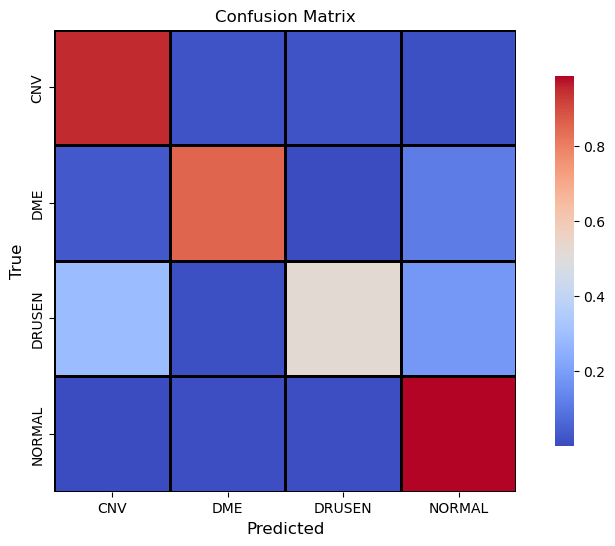

Evaluating model for Fold 2
Test Accuracy: 0.9107
Test Precision: 0.9100
Test Recall: 0.9107
Test F1-score: 0.9092
              precision    recall  f1-score   support

         CNV       0.89      0.98      0.93     12410
         DME       0.91      0.82      0.86      3809
      DRUSEN       0.66      0.59      0.62      2857
      NORMAL       0.96      0.94      0.95     17027

    accuracy                           0.91     36103
   macro avg       0.86      0.83      0.84     36103
weighted avg       0.91      0.91      0.91     36103



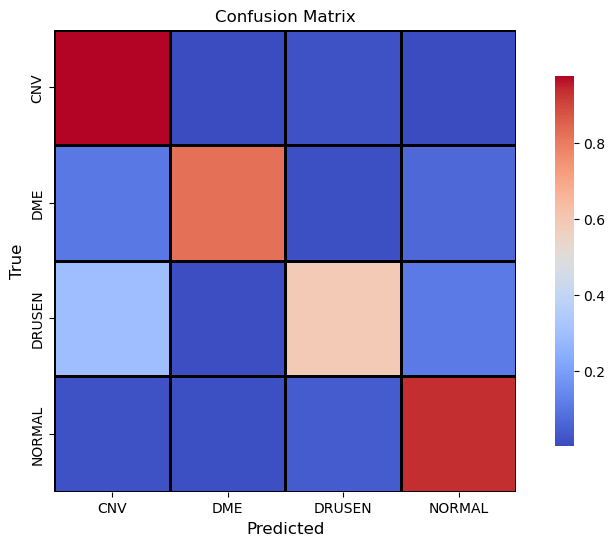

Evaluating model for Fold 3
Test Accuracy: 0.9205
Test Precision: 0.9213
Test Recall: 0.9205
Test F1-score: 0.9203
              precision    recall  f1-score   support

         CNV       0.96      0.92      0.94     12416
         DME       0.80      0.90      0.85      3651
      DRUSEN       0.74      0.68      0.71      2879
      NORMAL       0.95      0.97      0.96     17157

    accuracy                           0.92     36103
   macro avg       0.86      0.87      0.86     36103
weighted avg       0.92      0.92      0.92     36103



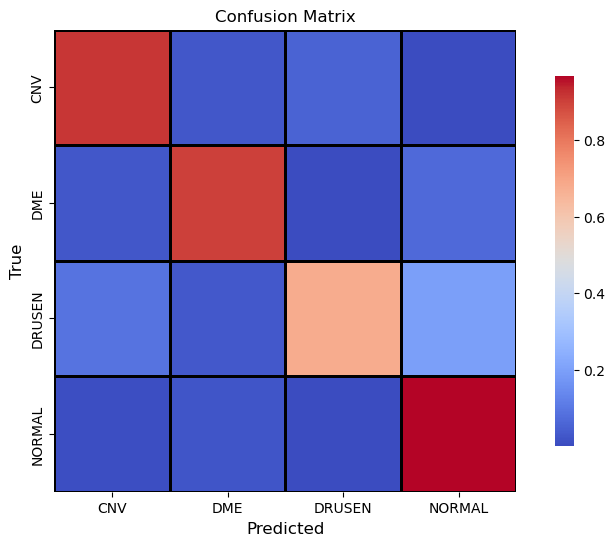

In [24]:
evaluate_model(ResNetGrayMulticlass, "exp0.05/resnetgraymulticlass_fold_{}.pth")

Evaluating model for Fold 1
Test Accuracy: 0.9065
Test Precision: 0.9053
Test Recall: 0.9065
Test F1-score: 0.8992
              precision    recall  f1-score   support

         CNV       0.91      0.94      0.93     12379
         DME       0.83      0.74      0.78      3888
      DRUSEN       0.91      0.47      0.62      2880
      NORMAL       0.92      1.00      0.95     16956

    accuracy                           0.91     36103
   macro avg       0.89      0.79      0.82     36103
weighted avg       0.91      0.91      0.90     36103



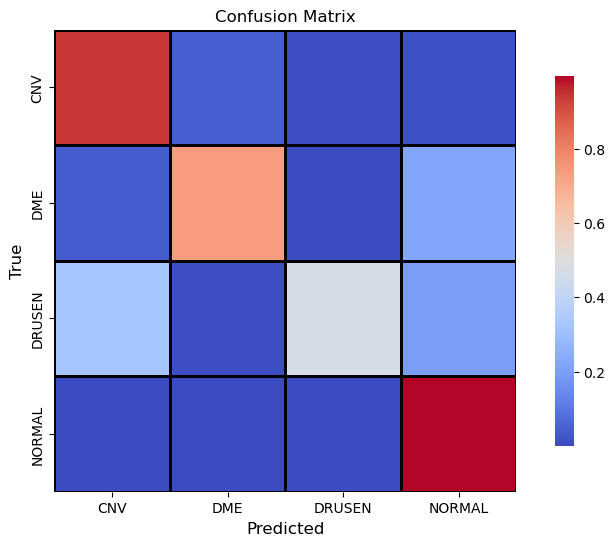

Evaluating model for Fold 2
Test Accuracy: 0.9302
Test Precision: 0.9313
Test Recall: 0.9302
Test F1-score: 0.9300
              precision    recall  f1-score   support

         CNV       0.96      0.91      0.94     12410
         DME       0.93      0.85      0.89      3809
      DRUSEN       0.71      0.74      0.73      2857
      NORMAL       0.94      0.99      0.97     17027

    accuracy                           0.93     36103
   macro avg       0.89      0.88      0.88     36103
weighted avg       0.93      0.93      0.93     36103



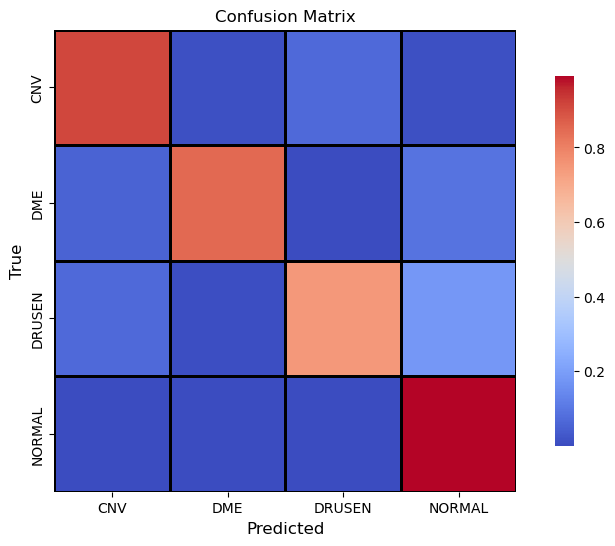

Evaluating model for Fold 3
Test Accuracy: 0.9282
Test Precision: 0.9273
Test Recall: 0.9282
Test F1-score: 0.9257
              precision    recall  f1-score   support

         CNV       0.91      0.97      0.94     12416
         DME       0.95      0.76      0.85      3651
      DRUSEN       0.78      0.66      0.72      2879
      NORMAL       0.96      0.97      0.97     17157

    accuracy                           0.93     36103
   macro avg       0.90      0.84      0.87     36103
weighted avg       0.93      0.93      0.93     36103



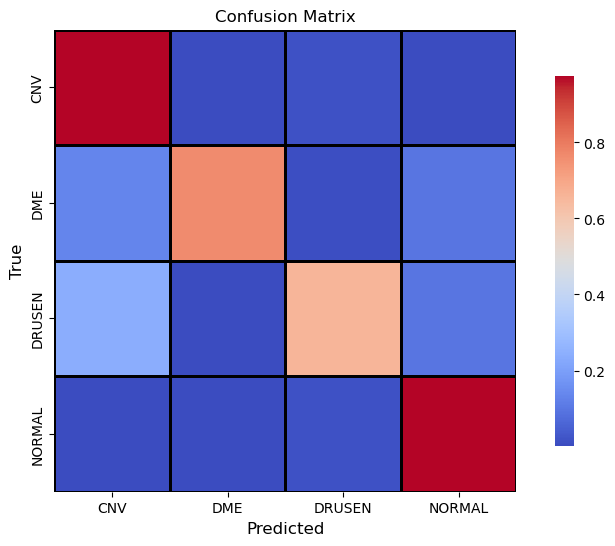

In [25]:
evaluate_model(InceptionV3GrayMulticlass, "exp0.05/inceptionv3graymulticlass_fold_{}.pth")

Evaluating model for Fold 1
Test Accuracy: 0.8844
Test Precision: 0.8886
Test Recall: 0.8844
Test F1-score: 0.8738
              precision    recall  f1-score   support

         CNV       0.93      0.92      0.93     12379
         DME       0.94      0.59      0.72      3888
      DRUSEN       0.86      0.44      0.58      2880
      NORMAL       0.85      1.00      0.92     16956

    accuracy                           0.88     36103
   macro avg       0.90      0.74      0.79     36103
weighted avg       0.89      0.88      0.87     36103



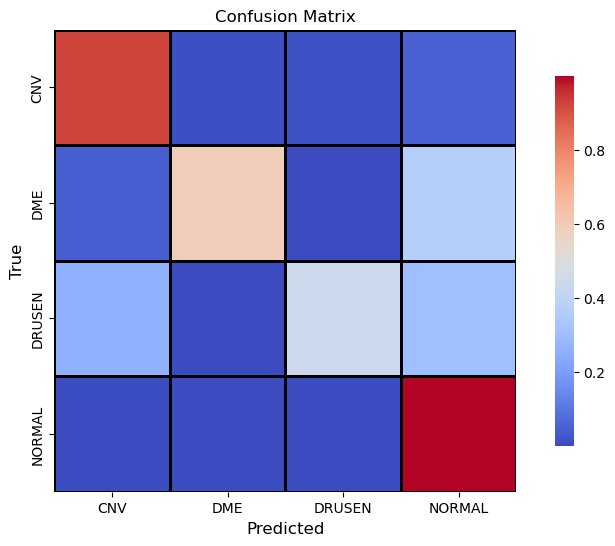

Evaluating model for Fold 2
Test Accuracy: 0.9133
Test Precision: 0.9123
Test Recall: 0.9133
Test F1-score: 0.9103
              precision    recall  f1-score   support

         CNV       0.89      0.96      0.93     12410
         DME       0.93      0.70      0.80      3809
      DRUSEN       0.77      0.66      0.71      2857
      NORMAL       0.95      0.97      0.96     17027

    accuracy                           0.91     36103
   macro avg       0.88      0.82      0.85     36103
weighted avg       0.91      0.91      0.91     36103



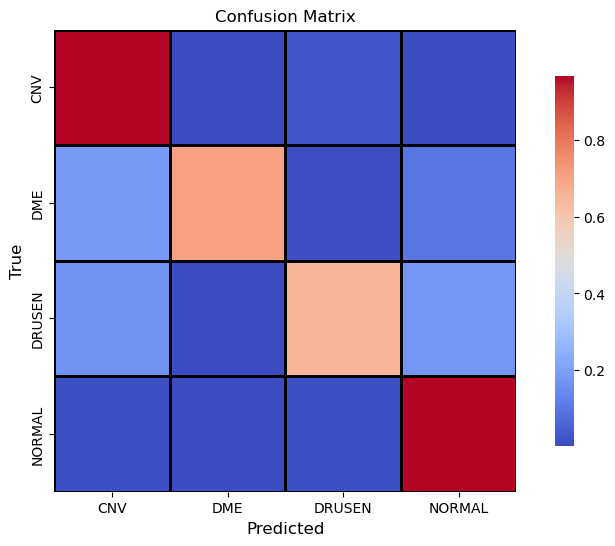

Evaluating model for Fold 3
Test Accuracy: 0.9206
Test Precision: 0.9201
Test Recall: 0.9206
Test F1-score: 0.9179
              precision    recall  f1-score   support

         CNV       0.95      0.94      0.94     12416
         DME       0.96      0.73      0.83      3651
      DRUSEN       0.75      0.67      0.71      2879
      NORMAL       0.92      0.99      0.96     17157

    accuracy                           0.92     36103
   macro avg       0.90      0.83      0.86     36103
weighted avg       0.92      0.92      0.92     36103



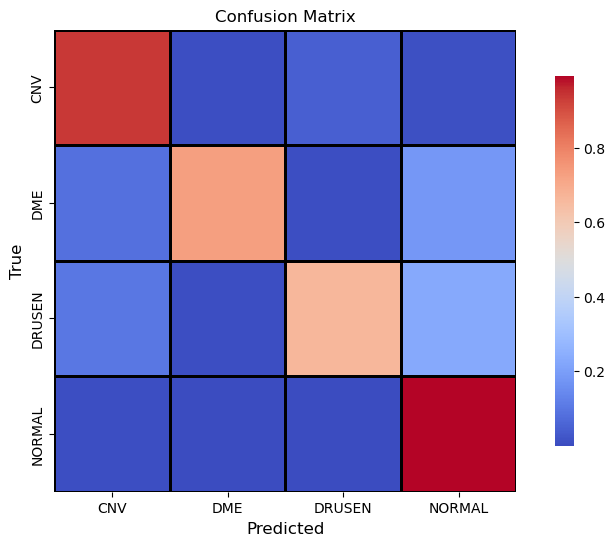

In [26]:
evaluate_model(DenseNet121GrayMulticlass, "exp0.05/densenet121graymulticlass_fold_{}.pth")

Evaluating model for Fold 1
Test Accuracy: 0.9295
Test Precision: 0.9280
Test Recall: 0.9295
Test F1-score: 0.9266
              precision    recall  f1-score   support

         CNV       0.93      0.95      0.94     12379
         DME       0.85      0.89      0.87      3888
      DRUSEN       0.87      0.60      0.71      2880
      NORMAL       0.95      0.98      0.97     16956

    accuracy                           0.93     36103
   macro avg       0.90      0.86      0.87     36103
weighted avg       0.93      0.93      0.93     36103



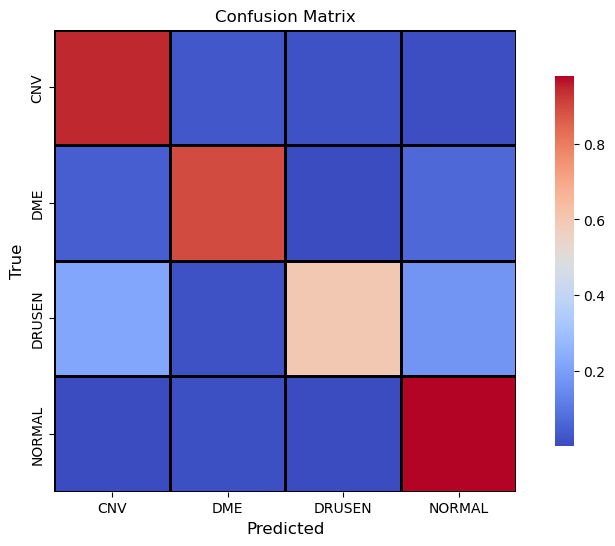

Evaluating model for Fold 2
Test Accuracy: 0.9259
Test Precision: 0.9253
Test Recall: 0.9259
Test F1-score: 0.9248
              precision    recall  f1-score   support

         CNV       0.96      0.91      0.94     12410
         DME       0.88      0.85      0.86      3809
      DRUSEN       0.75      0.70      0.73      2857
      NORMAL       0.94      0.99      0.96     17027

    accuracy                           0.93     36103
   macro avg       0.88      0.86      0.87     36103
weighted avg       0.93      0.93      0.92     36103



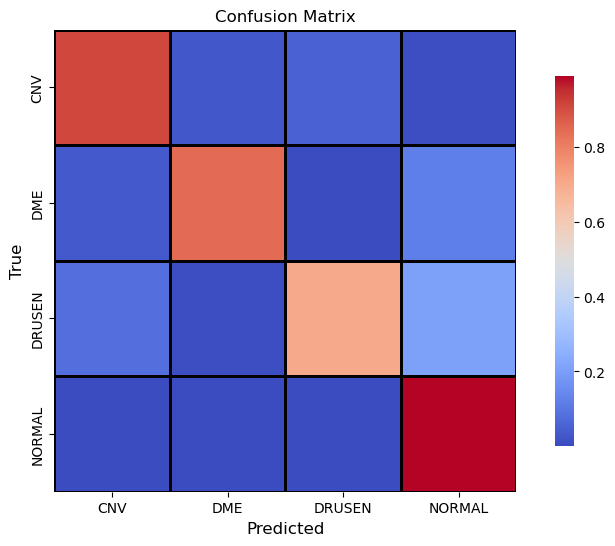

Evaluating model for Fold 3
Test Accuracy: 0.9300
Test Precision: 0.9285
Test Recall: 0.9300
Test F1-score: 0.9282
              precision    recall  f1-score   support

         CNV       0.95      0.94      0.94     12416
         DME       0.94      0.80      0.87      3651
      DRUSEN       0.76      0.69      0.72      2879
      NORMAL       0.94      0.99      0.97     17157

    accuracy                           0.93     36103
   macro avg       0.90      0.85      0.87     36103
weighted avg       0.93      0.93      0.93     36103



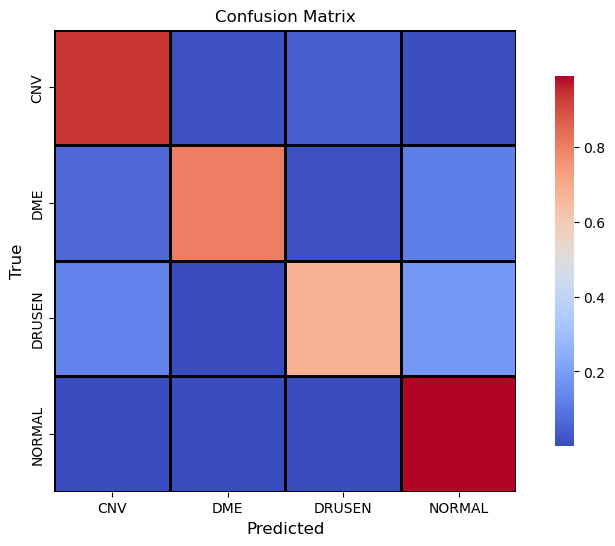

In [27]:
evaluate_model(EnsembleModel, "exp0.05/ensemblemodel_fold_{}.pth")

### 10%

Evaluating model for Fold 1
Test Accuracy: 0.9380
Test Precision: 0.9369
Test Recall: 0.9380
Test F1-score: 0.9346
              precision    recall  f1-score   support

         CNV       0.93      0.97      0.95     12379
         DME       0.94      0.84      0.89      3888
      DRUSEN       0.90      0.61      0.73      2880
      NORMAL       0.95      0.99      0.97     16956

    accuracy                           0.94     36103
   macro avg       0.93      0.85      0.88     36103
weighted avg       0.94      0.94      0.93     36103



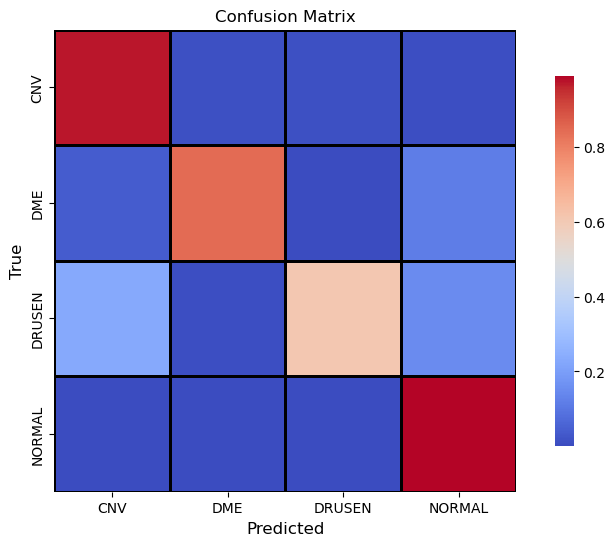

Evaluating model for Fold 2
Test Accuracy: 0.9377
Test Precision: 0.9363
Test Recall: 0.9377
Test F1-score: 0.9355
              precision    recall  f1-score   support

         CNV       0.93      0.97      0.95     12410
         DME       0.96      0.82      0.88      3809
      DRUSEN       0.84      0.67      0.75      2857
      NORMAL       0.96      0.98      0.97     17027

    accuracy                           0.94     36103
   macro avg       0.92      0.86      0.89     36103
weighted avg       0.94      0.94      0.94     36103



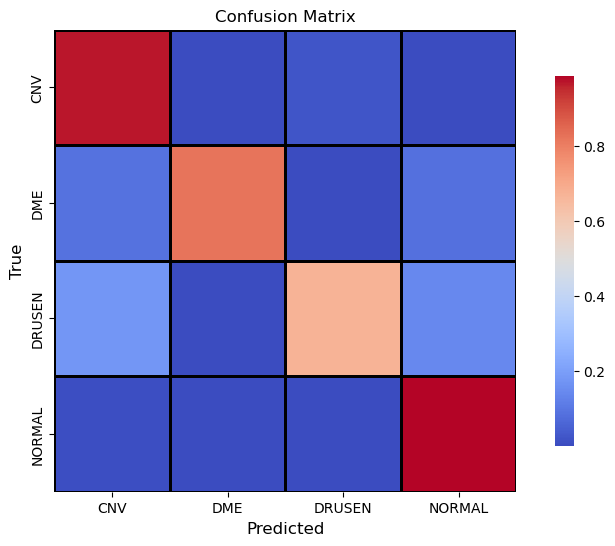

Evaluating model for Fold 3
Test Accuracy: 0.9395
Test Precision: 0.9374
Test Recall: 0.9395
Test F1-score: 0.9366
              precision    recall  f1-score   support

         CNV       0.94      0.97      0.95     12416
         DME       0.92      0.87      0.90      3651
      DRUSEN       0.86      0.62      0.72      2879
      NORMAL       0.95      0.99      0.97     17157

    accuracy                           0.94     36103
   macro avg       0.92      0.86      0.89     36103
weighted avg       0.94      0.94      0.94     36103



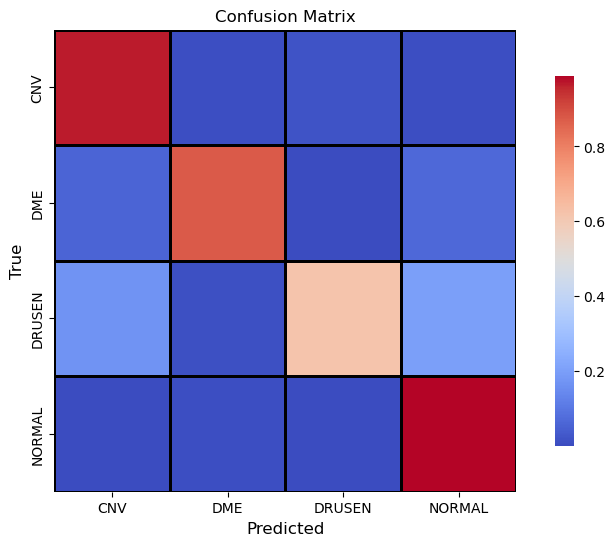

In [28]:
evaluate_model(ResNetGrayMulticlass, "exp0.1/resnetgraymulticlass_fold_{}.pth")

Evaluating model for Fold 1
Test Accuracy: 0.9421
Test Precision: 0.9412
Test Recall: 0.9421
Test F1-score: 0.9415
              precision    recall  f1-score   support

         CNV       0.95      0.96      0.95     12379
         DME       0.88      0.89      0.89      3888
      DRUSEN       0.82      0.75      0.79      2880
      NORMAL       0.97      0.97      0.97     16956

    accuracy                           0.94     36103
   macro avg       0.91      0.89      0.90     36103
weighted avg       0.94      0.94      0.94     36103



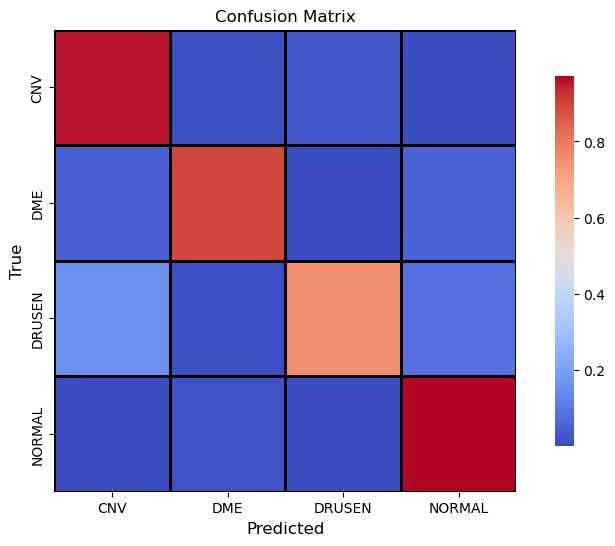

Evaluating model for Fold 2
Test Accuracy: 0.9385
Test Precision: 0.9369
Test Recall: 0.9385
Test F1-score: 0.9368
              precision    recall  f1-score   support

         CNV       0.96      0.94      0.95     12410
         DME       0.90      0.89      0.89      3809
      DRUSEN       0.83      0.68      0.75      2857
      NORMAL       0.95      0.99      0.97     17027

    accuracy                           0.94     36103
   macro avg       0.91      0.88      0.89     36103
weighted avg       0.94      0.94      0.94     36103



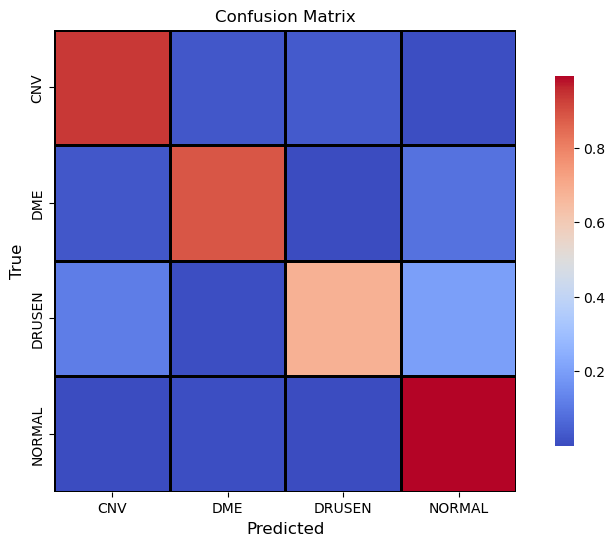

Evaluating model for Fold 3
Test Accuracy: 0.9179
Test Precision: 0.9293
Test Recall: 0.9179
Test F1-score: 0.9206
              precision    recall  f1-score   support

         CNV       0.98      0.85      0.91     12416
         DME       0.87      0.88      0.87      3651
      DRUSEN       0.61      0.85      0.71      2879
      NORMAL       0.96      0.98      0.97     17157

    accuracy                           0.92     36103
   macro avg       0.86      0.89      0.87     36103
weighted avg       0.93      0.92      0.92     36103



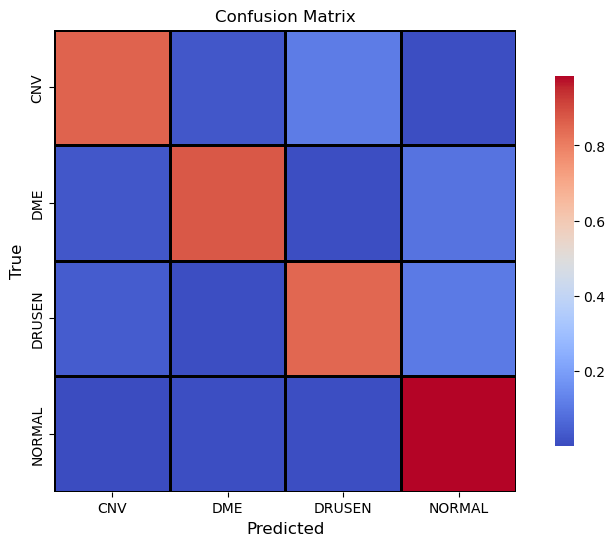

In [29]:
evaluate_model(InceptionV3GrayMulticlass, "exp0.1/inceptionv3graymulticlass_fold_{}.pth")

Evaluating model for Fold 1
Test Accuracy: 0.9314
Test Precision: 0.9309
Test Recall: 0.9314
Test F1-score: 0.9257
              precision    recall  f1-score   support

         CNV       0.91      0.97      0.94     12379
         DME       0.92      0.87      0.89      3888
      DRUSEN       0.91      0.50      0.65      2880
      NORMAL       0.95      0.99      0.97     16956

    accuracy                           0.93     36103
   macro avg       0.92      0.83      0.86     36103
weighted avg       0.93      0.93      0.93     36103



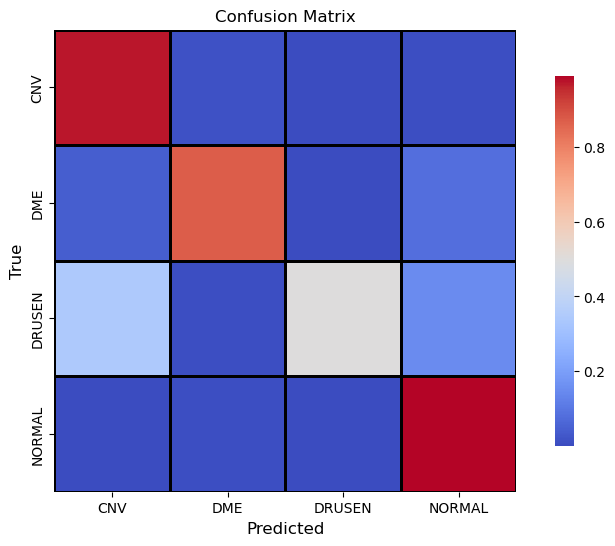

Evaluating model for Fold 2
Test Accuracy: 0.9316
Test Precision: 0.9305
Test Recall: 0.9316
Test F1-score: 0.9282
              precision    recall  f1-score   support

         CNV       0.93      0.97      0.95     12410
         DME       0.96      0.77      0.85      3809
      DRUSEN       0.85      0.64      0.73      2857
      NORMAL       0.94      0.99      0.96     17027

    accuracy                           0.93     36103
   macro avg       0.92      0.84      0.87     36103
weighted avg       0.93      0.93      0.93     36103



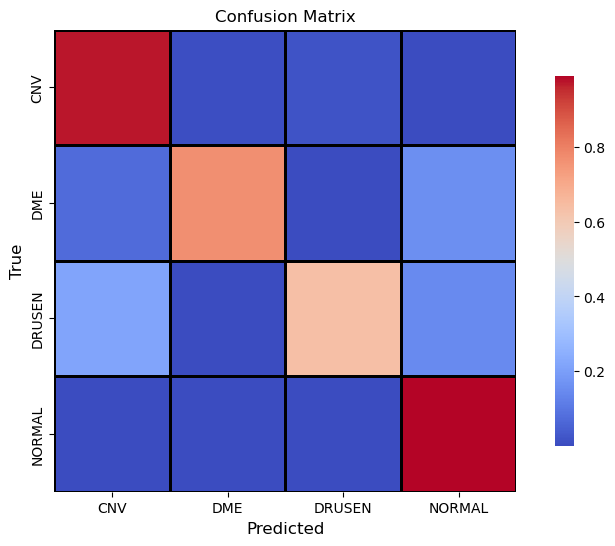

Evaluating model for Fold 3
Test Accuracy: 0.9385
Test Precision: 0.9375
Test Recall: 0.9385
Test F1-score: 0.9366
              precision    recall  f1-score   support

         CNV       0.95      0.95      0.95     12416
         DME       0.86      0.92      0.89      3651
      DRUSEN       0.87      0.65      0.74      2879
      NORMAL       0.96      0.98      0.97     17157

    accuracy                           0.94     36103
   macro avg       0.91      0.88      0.89     36103
weighted avg       0.94      0.94      0.94     36103



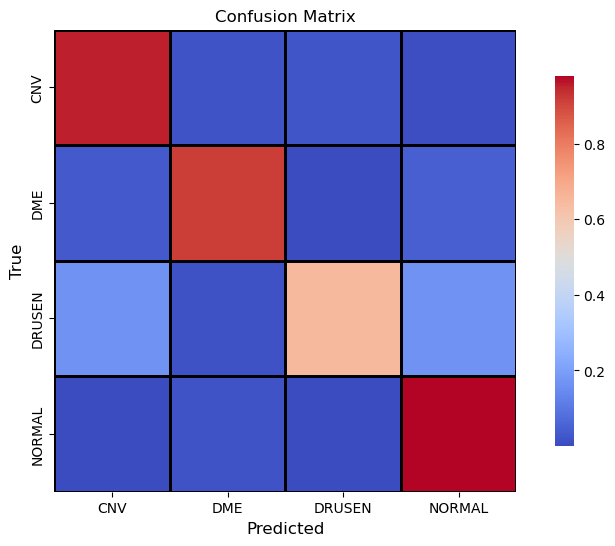

In [30]:
evaluate_model(DenseNet121GrayMulticlass, "exp0.1/densenet121graymulticlass_fold_{}.pth")

Evaluating model for Fold 1
Test Accuracy: 0.9284
Test Precision: 0.9270
Test Recall: 0.9284
Test F1-score: 0.9255
              precision    recall  f1-score   support

         CNV       0.93      0.95      0.94     12379
         DME       0.85      0.90      0.87      3888
      DRUSEN       0.86      0.59      0.70      2880
      NORMAL       0.95      0.98      0.97     16956

    accuracy                           0.93     36103
   macro avg       0.90      0.85      0.87     36103
weighted avg       0.93      0.93      0.93     36103



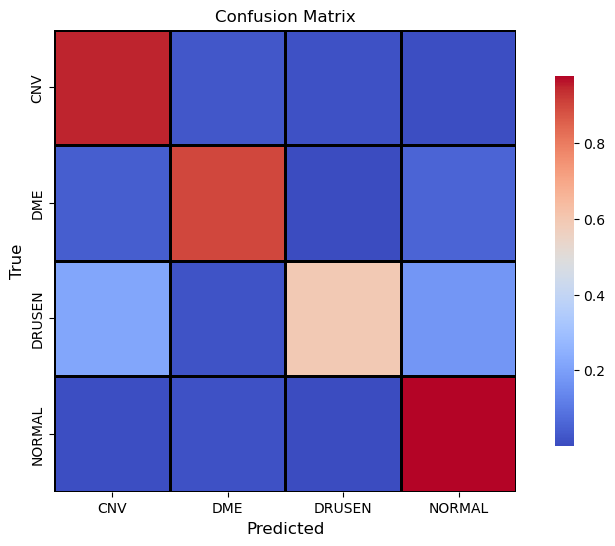

Evaluating model for Fold 2
Test Accuracy: 0.9246
Test Precision: 0.9238
Test Recall: 0.9246
Test F1-score: 0.9235
              precision    recall  f1-score   support

         CNV       0.96      0.91      0.94     12410
         DME       0.88      0.84      0.86      3809
      DRUSEN       0.75      0.70      0.72      2857
      NORMAL       0.94      0.99      0.96     17027

    accuracy                           0.92     36103
   macro avg       0.88      0.86      0.87     36103
weighted avg       0.92      0.92      0.92     36103



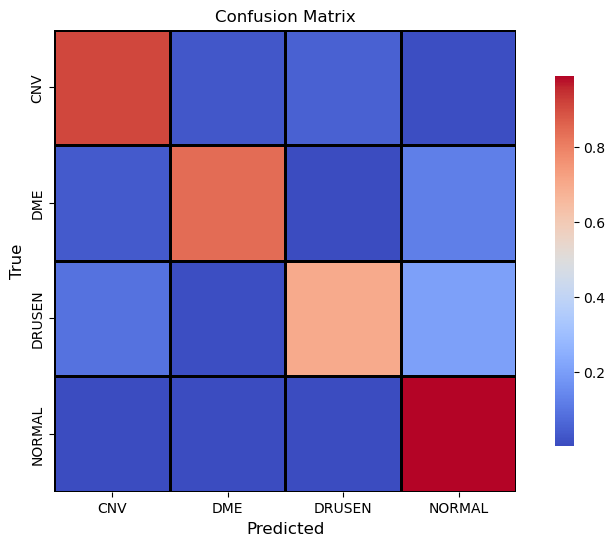

Evaluating model for Fold 3
Test Accuracy: 0.9285
Test Precision: 0.9272
Test Recall: 0.9285
Test F1-score: 0.9269
              precision    recall  f1-score   support

         CNV       0.94      0.94      0.94     12416
         DME       0.94      0.80      0.86      3651
      DRUSEN       0.75      0.69      0.72      2879
      NORMAL       0.94      0.99      0.97     17157

    accuracy                           0.93     36103
   macro avg       0.89      0.85      0.87     36103
weighted avg       0.93      0.93      0.93     36103



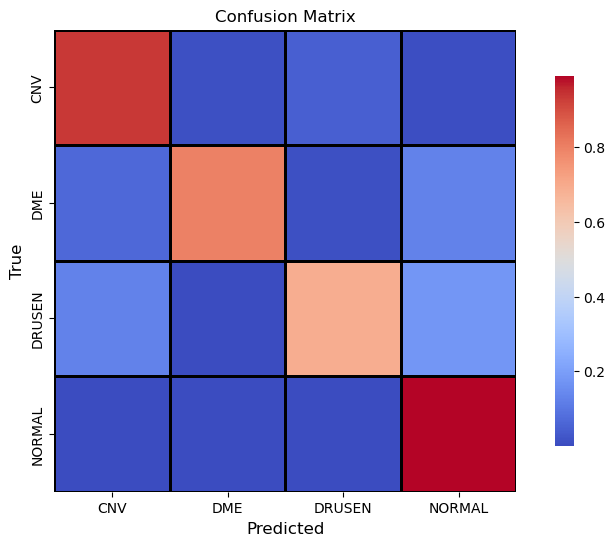

In [31]:
evaluate_model(EnsembleModel, "exp0.05/ensemblemodel_fold_{}.pth")

## Confusion Matrix

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []  # Initialize list to store predictions
    true_labels = []  # Initialize list to store true labels

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:  # Iterate over the dataloader
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU if available
            inputs_gray = inputs.mean(dim=1, keepdim=True)  # Convert inputs to grayscale
            outputs = model(inputs_gray)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get the predicted classes
            predictions.extend(preds.tolist())  # Store predictions
            true_labels.extend(labels.tolist())  # Store true labels

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
for fold_idx in range(kf.get_n_splits()):
    print(f"Evaluating ResNetGrayMulticlass model for Fold {fold_idx + 1}")
    resnet_model = ResNetGrayMulticlass(num_classes).to(device)
    resnet_model.load_state_dict(torch.load(f"0.05/resnetgraymulticlass_fold_{fold_idx + 1}.pth"))
    plot_confusion_matrix(resnet_model, dataloaders[fold_idx][TEST])

In [ ]:
# Plot confusion matrix for InceptionV3
print("\nConfusion Matrix for InceptionV3:")
plot_confusion_matrix(inception_model, dataloaders[fold_idx][TEST])

In [ ]:
# Plot confusion matrix for Ensemble Model
print("\nConfusion Matrix for Ensemble Model:")
plot_confusion_matrix(ensemble_model, dataloaders[fold_idx][TEST])

In [ ]:
# Plot confusion matrix for ResNet50
print("\nConfusion Matrix for ResNet50:")
plot_confusion_matrix(resnet_model, dataloaders[fold_idx][TEST])

In [ ]:
# Plot confusion matrix for DenseNet121
print("\nConfusion Matrix for DenseNet121:")
plot_confusion_matrix(densenet_model, dataloaders[fold_idx][TEST])

## Test with input

In [2]:
def predict_image_class(model, image_path, class_names):
    input_image = preprocess_image(image_path)
    
    with torch.no_grad():
        input_image_gray = input_image.mean(dim=1, keepdim=True)  # Convert to grayscale
        outputs = model(input_image_gray)
        _, preds = torch.max(outputs, 1)
        predicted_class = preds.item()
    
    return class_names[predicted_class]

In [ ]:
# Example usage
image_path = input("Enter the path to the image: ")
predicted_class = predict_image_class(resnet_model, image_path, class_names)
print(f"The predicted class is: {predicted_class}")